In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/Liquidity_Research/unified

audio_16k  checkpoint.json  metadata.csv  processing_log.json  splits.json


In [4]:
!pip install -q librosa soundfile matplotlib seaborn tqdm

In [5]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✅ Imports complete")

✅ Imports complete


In [6]:
# ============================================================
# CONFIGURATION - Update this path if needed
# ============================================================

BASE_DIR = Path("/content/drive/MyDrive/Liquidity_Research/unified")
AUDIO_DIR = BASE_DIR / "audio_16k"
METADATA_PATH = BASE_DIR / "metadata.csv"
SPLITS_PATH = BASE_DIR / "splits.json"
STATS_DIR = BASE_DIR / "stats"

# Create stats directory
STATS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Stats output:   {STATS_DIR}")
print(f"\nDirectory exists: {BASE_DIR.exists()}")

Base directory: /content/drive/MyDrive/Liquidity_Research/unified
Stats output:   /content/drive/MyDrive/Liquidity_Research/unified/stats

Directory exists: True


In [7]:
# Load metadata
df = pd.read_csv(METADATA_PATH)
print(f"Loaded {len(df):,} utterances")
print(f"\nColumns: {list(df.columns)}")
df.head()



Loaded 61,955 utterances

Columns: ['utt_id', 'speaker_id', 'dataset', 'audio_path', 'audio_path_original', 'duration', 'transcript', 'gender', 'emotion', 'accent']


,utt_id,speaker_id,dataset,audio_path,audio_path_original,duration,transcript,gender,emotion,accent
0,vctk_p225_001,vctk_p225,vctk,audio_16k/vctk_p225/vctk_p225_001.wav,D:\InterSpeech\dataset\wav48_silence_trimmed\p...,2.052,Please call Stella.,F,neutral,English
1,vctk_p225_002,vctk_p225,vctk,audio_16k/vctk_p225/vctk_p225_002.wav,D:\InterSpeech\dataset\wav48_silence_trimmed\p...,3.939,Ask her to bring these things with her from th...,F,neutral,English
2,vctk_p225_003,vctk_p225,vctk,audio_16k/vctk_p225/vctk_p225_003.wav,D:\InterSpeech\dataset\wav48_silence_trimmed\p...,7.588,"Six spoons of fresh snow peas, five thick slab...",F,neutral,English
3,vctk_p225_004,vctk_p225,vctk,audio_16k/vctk_p225/vctk_p225_004.wav,D:\InterSpeech\dataset\wav48_silence_trimmed\p...,4.411,We also need a small plastic snake and a big t...,F,neutral,English
4,vctk_p225_005,vctk_p225,vctk,audio_16k/vctk_p225/vctk_p225_005.wav,D:\InterSpeech\dataset\wav48_silence_trimmed\p...,6.323,She can scoop these things into three red bags...,F,neutral,English


In [8]:
# Load splits
with open(SPLITS_PATH, 'r') as f:
    splits = json.load(f)

print("Splits configuration:")
print(json.dumps(splits['config'], indent=2))
print(f"\nTrain: {splits['train']['num_speakers']} speakers, {splits['train']['num_utterances']} utterances")
print(f"Val:   {splits['val']['num_speakers']} speakers, {splits['val']['num_utterances']} utterances")
print(f"Test:  {splits['test']['num_speakers']} speakers, {splits['test']['num_utterances']} utterances")


Splits configuration:
{
  "train_ratio": 0.7,
  "val_ratio": 0.15,
  "test_ratio": 0.15,
  "seed": 42,
  "split_by": "speaker"
}

Train: 84 speakers, 43215 utterances
Val:   18 speakers, 10041 utterances
Test:  18 speakers, 8699 utterances


In [9]:
# ============================================================
# OVERALL STATISTICS
# ============================================================

stats = {
    'total_utterances': len(df),
    'total_speakers': df['speaker_id'].nunique(),
    'total_duration_hours': df['duration'].sum() / 3600,
    'total_duration_seconds': df['duration'].sum(),
    'avg_duration': df['duration'].mean(),
    'min_duration': df['duration'].min(),
    'max_duration': df['duration'].max(),
    'median_duration': df['duration'].median(),
    'std_duration': df['duration'].std(),
}

print("="*60)
print("OVERALL DATASET STATISTICS")
print("="*60)
print(f"Total utterances:     {stats['total_utterances']:,}")
print(f"Total speakers:       {stats['total_speakers']}")
print(f"Total duration:       {stats['total_duration_hours']:.2f} hours")
print(f"")
print(f"Duration statistics:")
print(f"  Min:    {stats['min_duration']:.2f}s")
print(f"  Max:    {stats['max_duration']:.2f}s")
print(f"  Mean:   {stats['avg_duration']:.2f}s")
print(f"  Median: {stats['median_duration']:.2f}s")
print(f"  Std:    {stats['std_duration']:.2f}s")

OVERALL DATASET STATISTICS
Total utterances:     61,955
Total speakers:       120
Total duration:       55.03 hours

Duration statistics:
  Min:    1.14s
  Max:    16.56s
  Mean:   3.20s
  Median: 2.98s
  Std:    1.11s


In [10]:

# ============================================================
# BY DATASET (VCTK vs ESD)
# ============================================================

dataset_stats = df.groupby('dataset').agg({
    'utt_id': 'count',
    'speaker_id': 'nunique',
    'duration': ['sum', 'mean', 'min', 'max', 'std']
}).round(3)

dataset_stats.columns = ['utterances', 'speakers', 'total_sec', 'avg_sec', 'min_sec', 'max_sec', 'std_sec']
dataset_stats['hours'] = dataset_stats['total_sec'] / 3600

print("\n" + "="*60)
print("BY DATASET")
print("="*60)
print(dataset_stats.to_string())

stats['by_dataset'] = dataset_stats.to_dict()



BY DATASET
         utterances  speakers   total_sec  avg_sec  min_sec  max_sec  std_sec      hours
dataset                                                                                 
esd           17500        10   48286.912    2.759    1.139    6.714    0.662  13.413031
vctk          44455       110  149815.667    3.370    1.220   16.557    1.200  41.615463


In [11]:
# ============================================================
# BY GENDER
# ============================================================

gender_stats = df.groupby('gender').agg({
    'utt_id': 'count',
    'speaker_id': 'nunique',
    'duration': 'sum'
}).round(3)
gender_stats.columns = ['utterances', 'speakers', 'total_sec']
gender_stats['hours'] = gender_stats['total_sec'] / 3600
gender_stats['pct'] = (gender_stats['utterances'] / len(df) * 100).round(1)

print("\n" + "="*60)
print("BY GENDER")
print("="*60)
print(gender_stats.to_string())

stats['by_gender'] = gender_stats.to_dict()


BY GENDER
        utterances  speakers   total_sec      hours   pct
gender                                                   
F            34369        68  112605.303  31.279251  55.5
M            27586        52   85497.276  23.749243  44.5


In [12]:
# ============================================================
# BY EMOTION (Important for ESD)
# ============================================================

emotion_stats = df.groupby('emotion').agg({
    'utt_id': 'count',
    'speaker_id': 'nunique',
    'duration': 'sum'
}).round(3)
emotion_stats.columns = ['utterances', 'speakers', 'total_sec']
emotion_stats['hours'] = emotion_stats['total_sec'] / 3600
emotion_stats['pct'] = (emotion_stats['utterances'] / len(df) * 100).round(1)

print("\n" + "="*60)
print("BY EMOTION")
print("="*60)
print(emotion_stats.sort_values('utterances', ascending=False).to_string())

stats['by_emotion'] = emotion_stats.to_dict()



BY EMOTION
          utterances  speakers   total_sec      hours   pct
emotion                                                    
neutral        47955       120  158899.885  44.138857  77.4
angry           3500        10    9787.446   2.718735   5.6
happy           3500        10    9440.114   2.622254   5.6
sad             3500        10   10424.374   2.895659   5.6
surprise        3500        10    9550.760   2.652989   5.6


In [13]:
# ============================================================
# BY ACCENT (VCTK has various accents)
# ============================================================

accent_stats = df.groupby('accent').agg({
    'utt_id': 'count',
    'speaker_id': 'nunique',
    'duration': 'sum'
}).round(3)
accent_stats.columns = ['utterances', 'speakers', 'total_sec']
accent_stats['hours'] = accent_stats['total_sec'] / 3600
accent_stats['pct'] = (accent_stats['utterances'] / len(df) * 100).round(1)

print("\n" + "="*60)
print("BY ACCENT")
print("="*60)
print(accent_stats.sort_values('utterances', ascending=False).to_string())

stats['by_accent'] = accent_stats.to_dict()


BY ACCENT
               utterances  speakers  total_sec      hours   pct
accent                                                         
American            26075        32  78602.054  21.833904  42.1
English             13636        33  43937.001  12.204722  22.0
Scottish             7611        19  25322.440   7.034011  12.3
Irish                3623         9  12155.042   3.376401   5.8
Canadian             3151         8  11114.286   3.087302   5.1
NorthernIrish        2580         6   8880.383   2.466773   4.2
SouthAfrican         1687         4   5641.153   1.566987   2.7
Indian               1164         3   3818.400   1.060667   1.9
Australian            823         2   2654.073   0.737242   1.3
NewZealand            422         1   1624.611   0.451281   0.7
Unknown               410         1   1513.352   0.420376   0.7
British               398         1   1692.141   0.470039   0.6
Welsh                 375         1   1147.643   0.318790   0.6


In [14]:
# ============================================================
# PER-SPEAKER STATISTICS
# ============================================================

speaker_stats = df.groupby('speaker_id').agg({
    'utt_id': 'count',
    'duration': ['sum', 'mean'],
    'dataset': 'first',
    'gender': 'first',
    'accent': 'first'
}).round(3)
speaker_stats.columns = ['utterances', 'total_sec', 'avg_sec', 'dataset', 'gender', 'accent']
speaker_stats['minutes'] = speaker_stats['total_sec'] / 60

print("\n" + "="*60)
print("PER-SPEAKER STATISTICS")
print("="*60)
print(f"Utterances per speaker:")
print(f"  Min:    {speaker_stats['utterances'].min()}")
print(f"  Max:    {speaker_stats['utterances'].max()}")
print(f"  Mean:   {speaker_stats['utterances'].mean():.1f}")
print(f"  Median: {speaker_stats['utterances'].median():.1f}")
print(f"")
print(f"Duration per speaker:")
print(f"  Min:    {speaker_stats['minutes'].min():.1f} minutes")
print(f"  Max:    {speaker_stats['minutes'].max():.1f} minutes")
print(f"  Mean:   {speaker_stats['minutes'].mean():.1f} minutes")
print(f"  Median: {speaker_stats['minutes'].median():.1f} minutes")

# Top 10 speakers by utterances
print("\nTop 10 speakers by utterances:")
print(speaker_stats.nlargest(10, 'utterances')[['utterances', 'minutes', 'dataset', 'gender']].to_string())



PER-SPEAKER STATISTICS
Utterances per speaker:
  Min:    123
  Max:    1750
  Mean:   516.3
  Median: 419.5

Duration per speaker:
  Min:    6.7 minutes
  Max:    87.0 minutes
  Mean:   27.5 minutes
  Median: 22.7 minutes

Top 10 speakers by utterances:
            utterances    minutes dataset gender
speaker_id                                      
esd_0011          1750  75.565433     esd      F
esd_0012          1750  79.878900     esd      F
esd_0013          1750  87.000500     esd      F
esd_0014          1750  86.006850     esd      F
esd_0015          1750  77.643717     esd      F
esd_0016          1750  74.238517     esd      M
esd_0017          1750  79.663100     esd      M
esd_0018          1750  77.024283     esd      M
esd_0019          1750  81.465983     esd      M
esd_0020          1750  86.294583     esd      M


In [15]:
# ============================================================
# TRAIN/VAL/TEST SPLIT ANALYSIS
# ============================================================

# Add split column to dataframe
df['split'] = 'unknown'
df.loc[df['speaker_id'].isin(splits['train']['speakers']), 'split'] = 'train'
df.loc[df['speaker_id'].isin(splits['val']['speakers']), 'split'] = 'val'
df.loc[df['speaker_id'].isin(splits['test']['speakers']), 'split'] = 'test'

split_stats = df.groupby('split').agg({
    'utt_id': 'count',
    'speaker_id': 'nunique',
    'duration': 'sum'
}).round(3)
split_stats.columns = ['utterances', 'speakers', 'total_sec']
split_stats['hours'] = split_stats['total_sec'] / 3600
split_stats['pct_utts'] = (split_stats['utterances'] / len(df) * 100).round(1)
split_stats['pct_spks'] = (split_stats['speakers'] / df['speaker_id'].nunique() * 100).round(1)

print("\n" + "="*60)
print("TRAIN/VAL/TEST SPLIT ANALYSIS")
print("="*60)
print(split_stats.to_string())

stats['by_split'] = split_stats.to_dict()


TRAIN/VAL/TEST SPLIT ANALYSIS
       utterances  speakers   total_sec      hours  pct_utts  pct_spks
split                                                                 
test         8699        18   27668.229   7.685619      14.0      15.0
train       43215        84  137899.368  38.305380      69.8      70.0
val         10041        18   32534.982   9.037495      16.2      15.0


In [16]:
# ============================================================
# CHECK SPLIT BALANCE BY GENDER, EMOTION, DATASET
# ============================================================

print("\n" + "="*60)
print("SPLIT BALANCE CHECK")
print("="*60)

# Gender balance per split
print("\nGender distribution per split:")
gender_split = pd.crosstab(df['split'], df['gender'], normalize='index') * 100
print(gender_split.round(1).to_string())

# Dataset balance per split
print("\nDataset distribution per split:")
dataset_split = pd.crosstab(df['split'], df['dataset'], normalize='index') * 100
print(dataset_split.round(1).to_string())

# Emotion distribution per split (mainly for ESD)
print("\nEmotion distribution per split:")
emotion_split = pd.crosstab(df['split'], df['emotion'], normalize='index') * 100
print(emotion_split.round(1).to_string())



SPLIT BALANCE CHECK

Gender distribution per split:
gender     F     M
split             
test    34.2  65.8
train   62.0  38.0
val     45.8  54.2

Dataset distribution per split:
dataset   esd  vctk
split              
test     20.1  79.9
train    28.3  71.7
val      34.9  65.1

Emotion distribution per split:
emotion  angry  happy  neutral  sad  surprise
split                                        
test       4.0    4.0     83.9  4.0       4.0
train      5.7    5.7     77.3  5.7       5.7
val        7.0    7.0     72.1  7.0       7.0


In [17]:
# ============================================================
# VERIFY AUDIO FILES EXIST
# ============================================================

print("\n" + "="*60)
print("VERIFYING AUDIO FILES")
print("="*60)

missing_files = []
existing_files = 0

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Checking files"):
    audio_path = BASE_DIR / row['audio_path']
    if audio_path.exists():
        existing_files += 1
    else:
        missing_files.append({
            'utt_id': row['utt_id'],
            'expected_path': str(audio_path)
        })

print(f"\nResults:")
print(f"  Existing:  {existing_files:,} ({existing_files/len(df)*100:.1f}%)")
print(f"  Missing:   {len(missing_files):,} ({len(missing_files)/len(df)*100:.1f}%)")

if missing_files:
    print(f"\nFirst 10 missing files:")
    for mf in missing_files[:10]:
        print(f"  {mf['utt_id']}")

stats['file_verification'] = {
    'existing': existing_files,
    'missing': len(missing_files),
    'missing_files': missing_files[:100]  # Save first 100 for debugging
}


VERIFYING AUDIO FILES


Checking files:   0%|          | 0/61955 [00:00<?, ?it/s]


Results:
  Existing:  61,911 (99.9%)
  Missing:   44 (0.1%)

First 10 missing files:
  esd_0011_angry_0011_000351
  esd_0011_angry_0011_000352
  esd_0011_angry_0011_000353
  esd_0011_angry_0011_000354
  esd_0011_angry_0011_000355
  esd_0011_angry_0011_000356
  esd_0011_angry_0011_000357
  esd_0011_angry_0011_000358
  esd_0011_angry_0011_000359
  esd_0011_angry_0011_000360


In [18]:
# ============================================================
# COUNT ACTUAL FILES ON DISK
# ============================================================

print("\n" + "="*60)
print("COUNTING FILES ON DISK")
print("="*60)

speaker_dirs = list(AUDIO_DIR.iterdir())
print(f"Speaker directories: {len(speaker_dirs)}")

file_counts = {}
total_files = 0

for spk_dir in tqdm(speaker_dirs, desc="Counting files"):
    if spk_dir.is_dir():
        wav_files = list(spk_dir.glob("*.wav"))
        file_counts[spk_dir.name] = len(wav_files)
        total_files += len(wav_files)

print(f"\nTotal .wav files on disk: {total_files:,}")
print(f"Total in metadata.csv:    {len(df):,}")
print(f"Difference:               {total_files - len(df):,}")

stats['disk_file_count'] = total_files



COUNTING FILES ON DISK
Speaker directories: 120


Counting files:   0%|          | 0/120 [00:00<?, ?it/s]


Total .wav files on disk: 61,911
Total in metadata.csv:    61,955
Difference:               -44


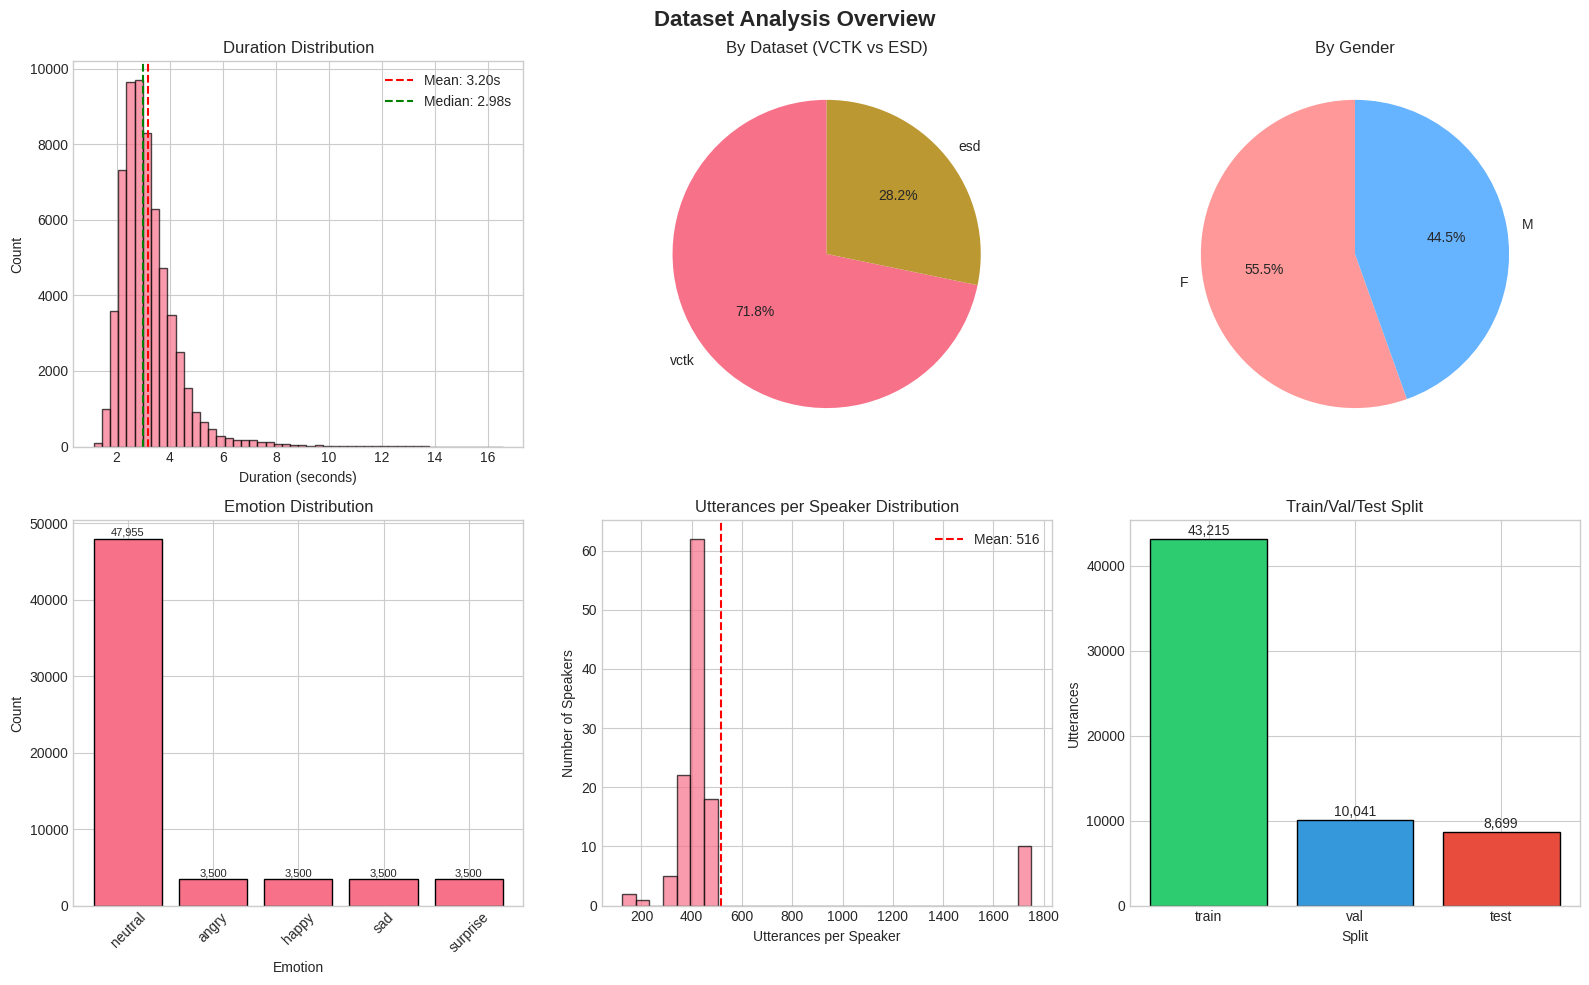


✅ Saved: /content/drive/MyDrive/Liquidity_Research/unified/stats/dataset_overview.png


In [19]:
# ============================================================
# CREATE VISUALIZATIONS
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Dataset Analysis Overview', fontsize=16, fontweight='bold')

# 1. Duration distribution
ax = axes[0, 0]
ax.hist(df['duration'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(df['duration'].mean(), color='red', linestyle='--', label=f'Mean: {df["duration"].mean():.2f}s')
ax.axvline(df['duration'].median(), color='green', linestyle='--', label=f'Median: {df["duration"].median():.2f}s')
ax.set_xlabel('Duration (seconds)')
ax.set_ylabel('Count')
ax.set_title('Duration Distribution')
ax.legend()

# 2. Dataset split
ax = axes[0, 1]
dataset_counts = df['dataset'].value_counts()
ax.pie(dataset_counts.values, labels=dataset_counts.index, autopct='%1.1f%%', startangle=90)
ax.set_title('By Dataset (VCTK vs ESD)')

# 3. Gender split
ax = axes[0, 2]
gender_counts = df['gender'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99']
ax.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=colors[:len(gender_counts)])
ax.set_title('By Gender')

# 4. Emotion distribution
ax = axes[1, 0]
emotion_counts = df['emotion'].value_counts()
bars = ax.bar(emotion_counts.index, emotion_counts.values, edgecolor='black')
ax.set_xlabel('Emotion')
ax.set_ylabel('Count')
ax.set_title('Emotion Distribution')
ax.tick_params(axis='x', rotation=45)
for bar, count in zip(bars, emotion_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, f'{count:,}', ha='center', va='bottom', fontsize=8)

# 5. Utterances per speaker
ax = axes[1, 1]
utts_per_speaker = df.groupby('speaker_id').size()
ax.hist(utts_per_speaker, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(utts_per_speaker.mean(), color='red', linestyle='--', label=f'Mean: {utts_per_speaker.mean():.0f}')
ax.set_xlabel('Utterances per Speaker')
ax.set_ylabel('Number of Speakers')
ax.set_title('Utterances per Speaker Distribution')
ax.legend()

# 6. Split distribution
ax = axes[1, 2]
split_counts = df['split'].value_counts()
colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax.bar(split_counts.index, split_counts.values, color=colors, edgecolor='black')
ax.set_xlabel('Split')
ax.set_ylabel('Utterances')
ax.set_title('Train/Val/Test Split')
for bar, count in zip(bars, split_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, f'{count:,}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(STATS_DIR / 'dataset_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✅ Saved: {STATS_DIR / 'dataset_overview.png'}")


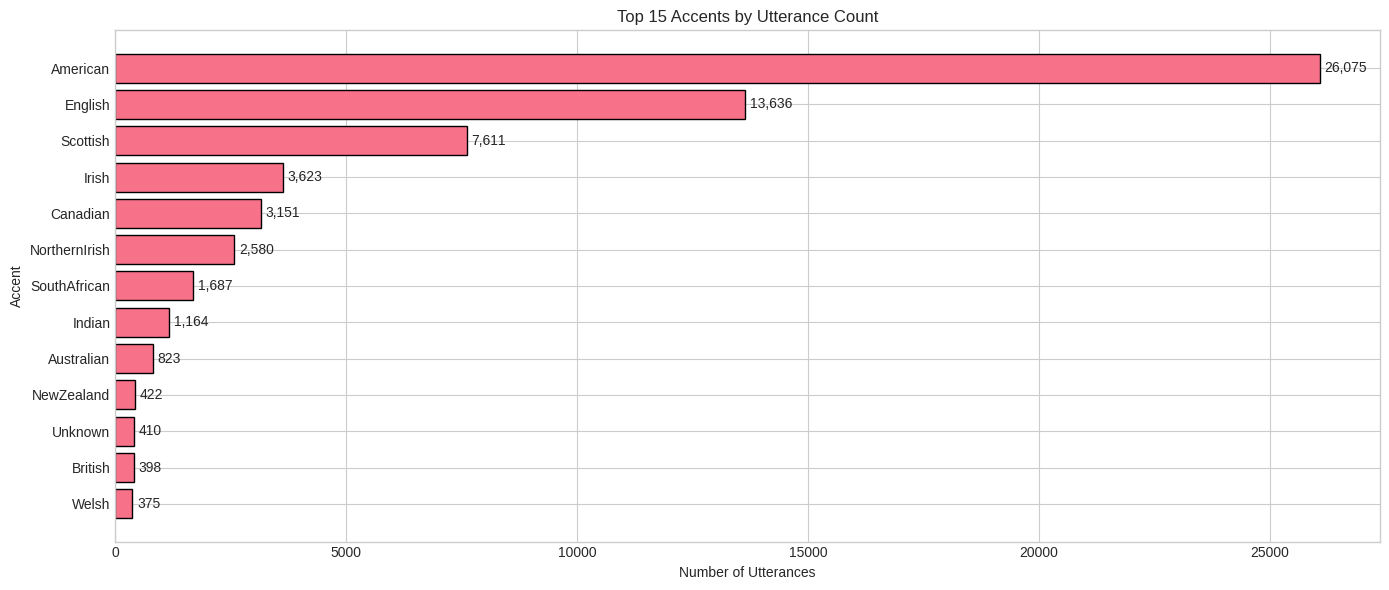

✅ Saved: /content/drive/MyDrive/Liquidity_Research/unified/stats/accent_distribution.png


In [20]:
# ============================================================
# ACCENT DISTRIBUTION (VCTK)
# ============================================================

fig, ax = plt.subplots(figsize=(14, 6))

accent_counts = df['accent'].value_counts().head(15)  # Top 15 accents
bars = ax.barh(accent_counts.index, accent_counts.values, edgecolor='black')
ax.set_xlabel('Number of Utterances')
ax.set_ylabel('Accent')
ax.set_title('Top 15 Accents by Utterance Count')
ax.invert_yaxis()

for bar, count in zip(bars, accent_counts.values):
    ax.text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2, f'{count:,}', va='center')

plt.tight_layout()
plt.savefig(STATS_DIR / 'accent_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {STATS_DIR / 'accent_distribution.png'}")

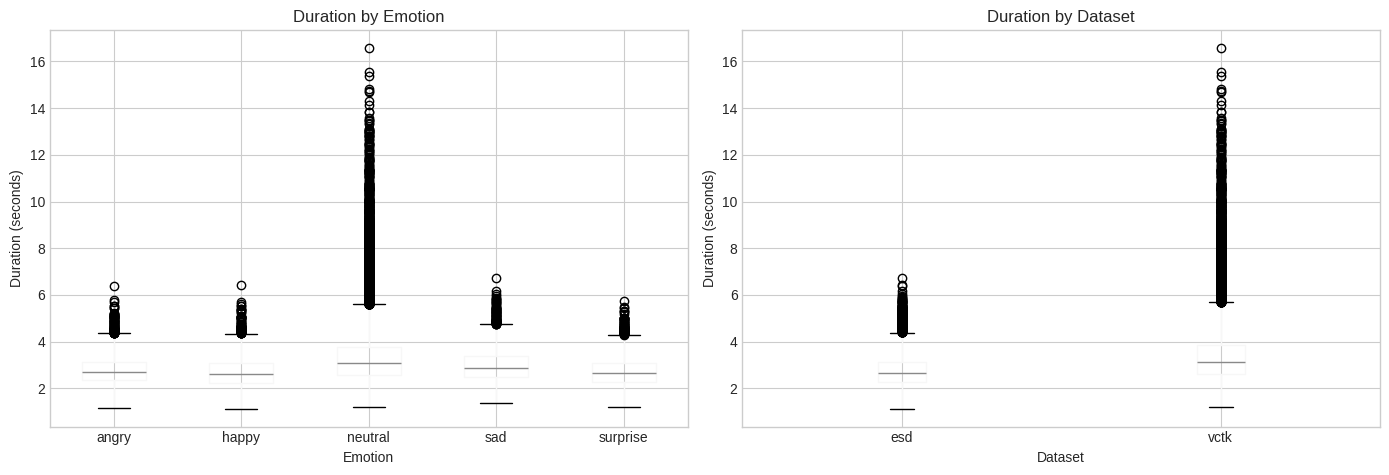

✅ Saved: /content/drive/MyDrive/Liquidity_Research/unified/stats/duration_analysis.png


In [21]:
# ============================================================
# DURATION BY EMOTION AND DATASET
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Duration by emotion
ax = axes[0]
df.boxplot(column='duration', by='emotion', ax=ax)
ax.set_xlabel('Emotion')
ax.set_ylabel('Duration (seconds)')
ax.set_title('Duration by Emotion')
plt.suptitle('')  # Remove automatic title

# Duration by dataset
ax = axes[1]
df.boxplot(column='duration', by='dataset', ax=ax)
ax.set_xlabel('Dataset')
ax.set_ylabel('Duration (seconds)')
ax.set_title('Duration by Dataset')
plt.suptitle('')

plt.tight_layout()
plt.savefig(STATS_DIR / 'duration_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {STATS_DIR / 'duration_analysis.png'}")

In [22]:
# ============================================================
# SAVE COMPREHENSIVE STATISTICS
# ============================================================

# Add timestamp
stats['generated_at'] = datetime.now().isoformat()
stats['metadata_path'] = str(METADATA_PATH)

# Save as JSON
stats_json_path = STATS_DIR / 'dataset_statistics.json'

# Convert numpy types to Python types for JSON serialization
def convert_to_serializable(obj):
    if isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    return obj

stats_serializable = convert_to_serializable(stats)

with open(stats_json_path, 'w') as f:
    json.dump(stats_serializable, f, indent=2)

print(f"✅ Saved: {stats_json_path}")


✅ Saved: /content/drive/MyDrive/Liquidity_Research/unified/stats/dataset_statistics.json


In [23]:
# ============================================================
# SAVE PER-SPEAKER STATISTICS
# ============================================================

speaker_stats_path = STATS_DIR / 'speaker_statistics.csv'
speaker_stats.to_csv(speaker_stats_path)
print(f"✅ Saved: {speaker_stats_path}")

✅ Saved: /content/drive/MyDrive/Liquidity_Research/unified/stats/speaker_statistics.csv


In [24]:
# ============================================================
# SAVE SPLIT SPEAKER LISTS
# ============================================================

# Detailed split info with speaker metadata
split_details = []

for split_name in ['train', 'val', 'test']:
    for spk in splits[split_name]['speakers']:
        spk_data = speaker_stats.loc[spk] if spk in speaker_stats.index else {}
        split_details.append({
            'speaker_id': spk,
            'split': split_name,
            'dataset': spk_data.get('dataset', ''),
            'gender': spk_data.get('gender', ''),
            'utterances': spk_data.get('utterances', 0),
            'minutes': spk_data.get('minutes', 0),
        })

split_details_df = pd.DataFrame(split_details)
split_details_path = STATS_DIR / 'split_details.csv'
split_details_df.to_csv(split_details_path, index=False)
print(f"✅ Saved: {split_details_path}")

✅ Saved: /content/drive/MyDrive/Liquidity_Research/unified/stats/split_details.csv


In [25]:
# ============================================================
# GENERATE SUMMARY REPORT
# ============================================================

report = f"""
================================================================================
DATASET ANALYSIS REPORT
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
================================================================================

OVERVIEW
--------
Total utterances:     {stats['total_utterances']:,}
Total speakers:       {stats['total_speakers']}
Total duration:       {stats['total_duration_hours']:.2f} hours

DURATION STATISTICS
-------------------
Min:    {stats['min_duration']:.2f}s
Max:    {stats['max_duration']:.2f}s
Mean:   {stats['avg_duration']:.2f}s
Median: {stats['median_duration']:.2f}s
Std:    {stats['std_duration']:.2f}s

BY DATASET
----------
{dataset_stats.to_string()}

BY GENDER
---------
{gender_stats.to_string()}

BY EMOTION
----------
{emotion_stats.to_string()}

TRAIN/VAL/TEST SPLIT
--------------------
{split_stats.to_string()}

FILE VERIFICATION
-----------------
Files on disk:     {stats.get('disk_file_count', 'N/A'):,}
Files in metadata: {stats['total_utterances']:,}
Missing files:     {stats['file_verification']['missing']}

================================================================================
FILES SAVED
================================================================================
- {STATS_DIR}/dataset_statistics.json
- {STATS_DIR}/speaker_statistics.csv
- {STATS_DIR}/split_details.csv
- {STATS_DIR}/dataset_overview.png
- {STATS_DIR}/accent_distribution.png
- {STATS_DIR}/duration_analysis.png
- {STATS_DIR}/analysis_report.txt
================================================================================
"""

report_path = STATS_DIR / 'analysis_report.txt'
with open(report_path, 'w') as f:
    f.write(report)

print(report)
print(f"\n✅ Saved: {report_path}")


DATASET ANALYSIS REPORT
Generated: 2026-01-07 16:23:59

OVERVIEW
--------
Total utterances:     61,955
Total speakers:       120
Total duration:       55.03 hours

DURATION STATISTICS
-------------------
Min:    1.14s
Max:    16.56s
Mean:   3.20s
Median: 2.98s
Std:    1.11s

BY DATASET
----------
         utterances  speakers   total_sec  avg_sec  min_sec  max_sec  std_sec      hours
dataset                                                                                 
esd           17500        10   48286.912    2.759    1.139    6.714    0.662  13.413031
vctk          44455       110  149815.667    3.370    1.220   16.557    1.200  41.615463

BY GENDER
---------
        utterances  speakers   total_sec      hours   pct
gender                                                   
F            34369        68  112605.303  31.279251  55.5
M            27586        52   85497.276  23.749243  44.5

BY EMOTION
----------
          utterances  speakers   total_sec      hours   pct
emotion  

In [26]:
# ============================================================
# ESTIMATE FEATURE EXTRACTION TIME & STORAGE
# ============================================================

total_hours = stats['total_duration_hours']
total_utts = stats['total_utterances']

print("\n" + "="*60)
print("FEATURE EXTRACTION ESTIMATES")
print("="*60)
print(f"\nBased on {total_utts:,} utterances ({total_hours:.1f} hours of audio)")

estimates = [
    {'feature': 'HuBERT continuous', 'gpu': True, 'time_per_utt': 0.1, 'storage_gb': 15},
    {'feature': 'K-means training (5 models)', 'gpu': True, 'time_per_utt': 0, 'storage_gb': 0.1, 'fixed_time': 2.5},
    {'feature': 'K-means assignment (all K)', 'gpu': False, 'time_per_utt': 0.01, 'storage_gb': 2},
    {'feature': 'FACodec (all codes)', 'gpu': True, 'time_per_utt': 0.2, 'storage_gb': 10},
    {'feature': 'EnCodec latents', 'gpu': True, 'time_per_utt': 0.1, 'storage_gb': 8},
    {'feature': 'F0 (CREPE)', 'gpu': True, 'time_per_utt': 0.3, 'storage_gb': 2},
    {'feature': 'Energy', 'gpu': False, 'time_per_utt': 0.01, 'storage_gb': 0.5},
    {'feature': 'Speaker embeddings (ECAPA)', 'gpu': True, 'time_per_utt': 0.05, 'storage_gb': 0.5},
    {'feature': 'MFA alignment', 'gpu': False, 'time_per_utt': 1.0, 'storage_gb': 1},
]

print(f"\n{'Feature':<30} {'GPU?':<6} {'Est. Time':<15} {'Storage':<10}")
print("-" * 65)

total_gpu_time = 0
total_cpu_time = 0
total_storage = 0

for est in estimates:
    if 'fixed_time' in est:
        time_hrs = est['fixed_time']
    else:
        time_hrs = (est['time_per_utt'] * total_utts) / 3600

    if est['gpu']:
        total_gpu_time += time_hrs
    else:
        total_cpu_time += time_hrs

    total_storage += est['storage_gb']

    gpu_str = '✅ GPU' if est['gpu'] else '❌ CPU'
    time_str = f"{time_hrs:.1f} hours"
    storage_str = f"{est['storage_gb']:.1f} GB"

    print(f"{est['feature']:<30} {gpu_str:<6} {time_str:<15} {storage_str:<10}")

print("-" * 65)
print(f"{'TOTAL GPU TIME':<30} {'':6} {total_gpu_time:.1f} hours")
print(f"{'TOTAL CPU TIME':<30} {'':6} {total_cpu_time:.1f} hours")
print(f"{'TOTAL STORAGE':<30} {'':6} {'':<15} {total_storage:.1f} GB")
print(f"\n⚡ With parallelization: ~{max(total_gpu_time, total_cpu_time):.1f} hours wall time")

# Save estimates
estimates_path = STATS_DIR / 'extraction_estimates.json'
with open(estimates_path, 'w') as f:
    json.dump({
        'total_utterances': total_utts,
        'total_hours_audio': total_hours,
        'estimates': estimates,
        'total_gpu_time_hours': total_gpu_time,
        'total_cpu_time_hours': total_cpu_time,
        'total_storage_gb': total_storage,
    }, f, indent=2)
print(f"\n✅ Saved: {estimates_path}")


FEATURE EXTRACTION ESTIMATES

Based on 61,955 utterances (55.0 hours of audio)

Feature                        GPU?   Est. Time       Storage   
-----------------------------------------------------------------
HuBERT continuous              ✅ GPU  1.7 hours       15.0 GB   
K-means training (5 models)    ✅ GPU  2.5 hours       0.1 GB    
K-means assignment (all K)     ❌ CPU  0.2 hours       2.0 GB    
FACodec (all codes)            ✅ GPU  3.4 hours       10.0 GB   
EnCodec latents                ✅ GPU  1.7 hours       8.0 GB    
F0 (CREPE)                     ✅ GPU  5.2 hours       2.0 GB    
Energy                         ❌ CPU  0.2 hours       0.5 GB    
Speaker embeddings (ECAPA)     ✅ GPU  0.9 hours       0.5 GB    
MFA alignment                  ❌ CPU  17.2 hours      1.0 GB    
-----------------------------------------------------------------
TOTAL GPU TIME                        15.4 hours
TOTAL CPU TIME                        17.6 hours
TOTAL STORAGE                          

In [27]:
# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "="*70)
print("✅ DATASET ANALYSIS COMPLETE")
print("="*70)

print(f"""
📊 YOUR DATASET:
   • {stats['total_utterances']:,} utterances
   • {stats['total_speakers']} speakers (109 VCTK + 10 ESD)
   • {stats['total_duration_hours']:.1f} hours of audio
   • Split: 70% train / 15% val / 15% test (by speaker)

📁 FILES CREATED IN {STATS_DIR}:
   • dataset_statistics.json    - All stats in JSON format
   • speaker_statistics.csv     - Per-speaker breakdown
   • split_details.csv          - Speaker assignments to splits
   • analysis_report.txt        - Human-readable report
   • dataset_overview.png       - Overview visualizations
   • accent_distribution.png    - Accent breakdown
   • duration_analysis.png      - Duration distributions
   • extraction_estimates.json  - Time/storage estimates

🚀 NEXT STEPS:
   1. Run feature extraction (HuBERT, FACodec, F0, etc.)
   2. Train probes on extracted features
   3. Build leakage matrix
""")

# List all files in stats directory
print(f"\n📂 Contents of {STATS_DIR}:")
for f in sorted(STATS_DIR.iterdir()):
    size = f.stat().st_size
    if size > 1024*1024:
        size_str = f"{size/1024/1024:.1f} MB"
    elif size > 1024:
        size_str = f"{size/1024:.1f} KB"
    else:
        size_str = f"{size} B"
    print(f"   {f.name:<35} {size_str:>10}")



✅ DATASET ANALYSIS COMPLETE

📊 YOUR DATASET:
   • 61,955 utterances
   • 120 speakers (109 VCTK + 10 ESD)
   • 55.0 hours of audio
   • Split: 70% train / 15% val / 15% test (by speaker)

📁 FILES CREATED IN /content/drive/MyDrive/Liquidity_Research/unified/stats:
   • dataset_statistics.json    - All stats in JSON format
   • speaker_statistics.csv     - Per-speaker breakdown
   • split_details.csv          - Speaker assignments to splits
   • analysis_report.txt        - Human-readable report
   • dataset_overview.png       - Overview visualizations
   • accent_distribution.png    - Accent breakdown
   • duration_analysis.png      - Duration distributions
   • extraction_estimates.json  - Time/storage estimates

🚀 NEXT STEPS:
   1. Run feature extraction (HuBERT, FACodec, F0, etc.)
   2. Train probes on extracted features
   3. Build leakage matrix


📂 Contents of /content/drive/MyDrive/Liquidity_Research/unified/stats:
   accent_distribution.png                72.6 KB
   analysis_re